# Plot the results of the filtering

In [10]:
import pandas as pd
import create_actionshist_keys
import matplotlib.pyplot as plt
import numpy as np

In [41]:
reload(create_actionshist_keys)

<module 'create_actionshist_keys' from 'create_actionshist_keys.py'>

In [42]:
actionshist_path = '/eos/user/l/llayer/AIErrorLogAnalysis/spark/data/actionshistory_300719.json'
data = create_actionshist_keys.load_data(actionshist_path)
keys_non_neg = create_actionshist_keys.get_keys(actionshist_path)
keys_all = create_actionshist_keys.get_keys(actionshist_path, ignore_neg_code = False)

In [22]:
# Number of workflows 
print 'Number of workflows', len(data)
print
# Number of workflows
print 'All (task_name, site, error) keys'
print 'Number of all unique keys:', len(keys_all)
print 'Number of all unique sites:', len(keys_all['site'].unique())
print 'Number of all unique errors:', len(keys_all['error'].unique())
print
print 'All (task_name, site, error) keys with error != -1'
print 'Number of all unique keys:', len(keys_non_neg)
print 'Number of all unique sites:', len(keys_non_neg['site'].unique())
print 'Number of all unique errors:', len(keys_non_neg['error'].unique())

Number of workflows 33586

All (task_name, site, error) keys
Number of all unique keys: 701344
Number of all unique sites: 154
Number of all unique errors: 77

All (task_name, site, error) keys with error != -1
Number of all unique keys: 147190
Number of all unique sites: 81
Number of all unique errors: 76


## 1. Plot the frequency of the errors and sites

In [121]:
def plot_counts(keys, key, x_label = 'error_code', weighted = True):
    
    if weighted == False:
        counts = keys[key].value_counts().to_frame('counts')
        labels = counts.index
    
    else:
        counts = keys.groupby(key)['count'].sum().to_frame('counts').reset_index()
        counts = counts.sort_values(['counts'], ascending = False)
        labels = list(counts[key])
        print len(list(counts.counts))
        #labels = keys.error

    if key == 'site':
        l = []
        for label in labels:
            try: 
                l.append(label.encode('utf-8'))           
            except:
                l.append('T3_US_NERSC'.encode('utf-8'))
        labels = l
        
    x = np.arange(len(counts))
    y = counts.counts
    width = 0.35                      
    
    fig, ax = plt.subplots(figsize=(20,10))
    rects1 = ax.bar(x, y, width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel(x_label)
    ax.set_ylabel('Number')
    #ax.set_xticks(x)
    #ax.set_xticklabels(labels)
    plt.xticks(x, labels, rotation='vertical')
    ax.legend()

    fig.tight_layout()

    #plt.show()
    #plt.savefig('number_errors.png')

### Weighted by counts

77


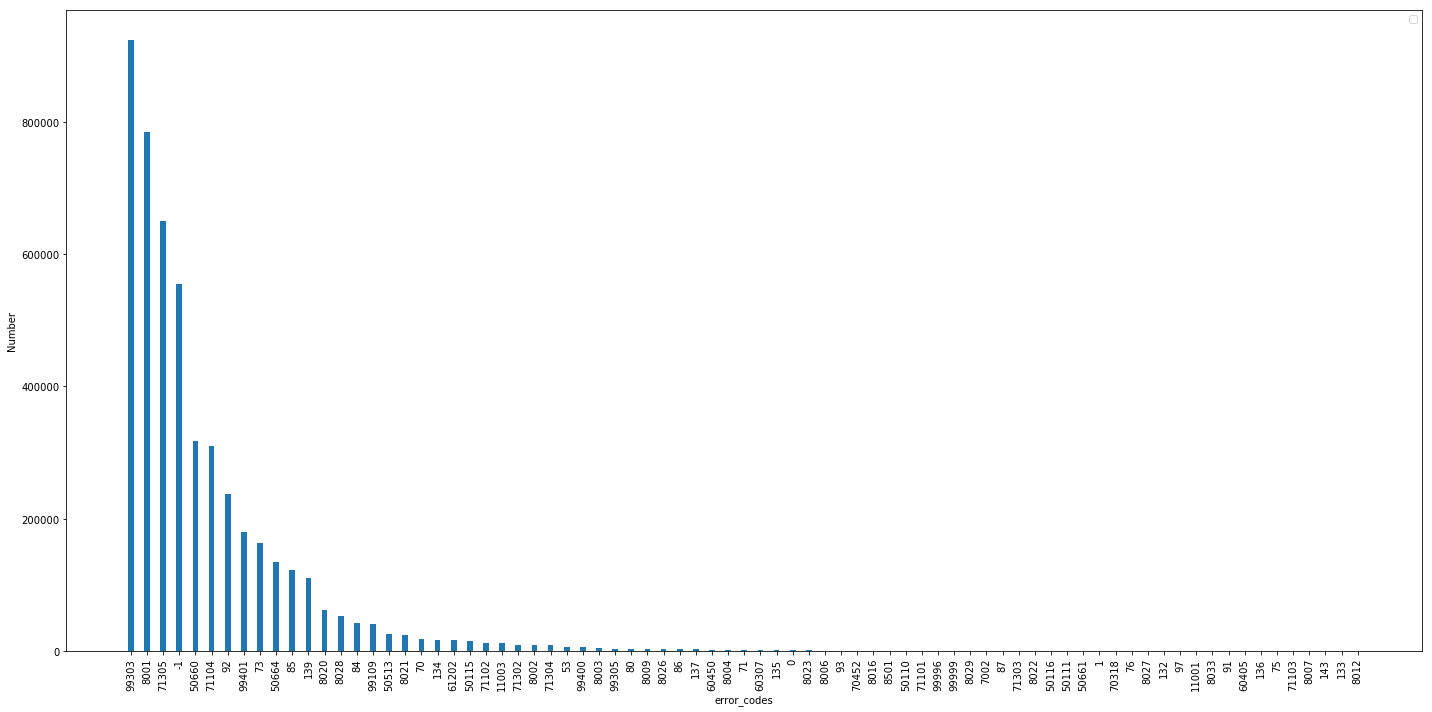

In [123]:
plot_counts(keys_all, 'error', 'error_codes')

154


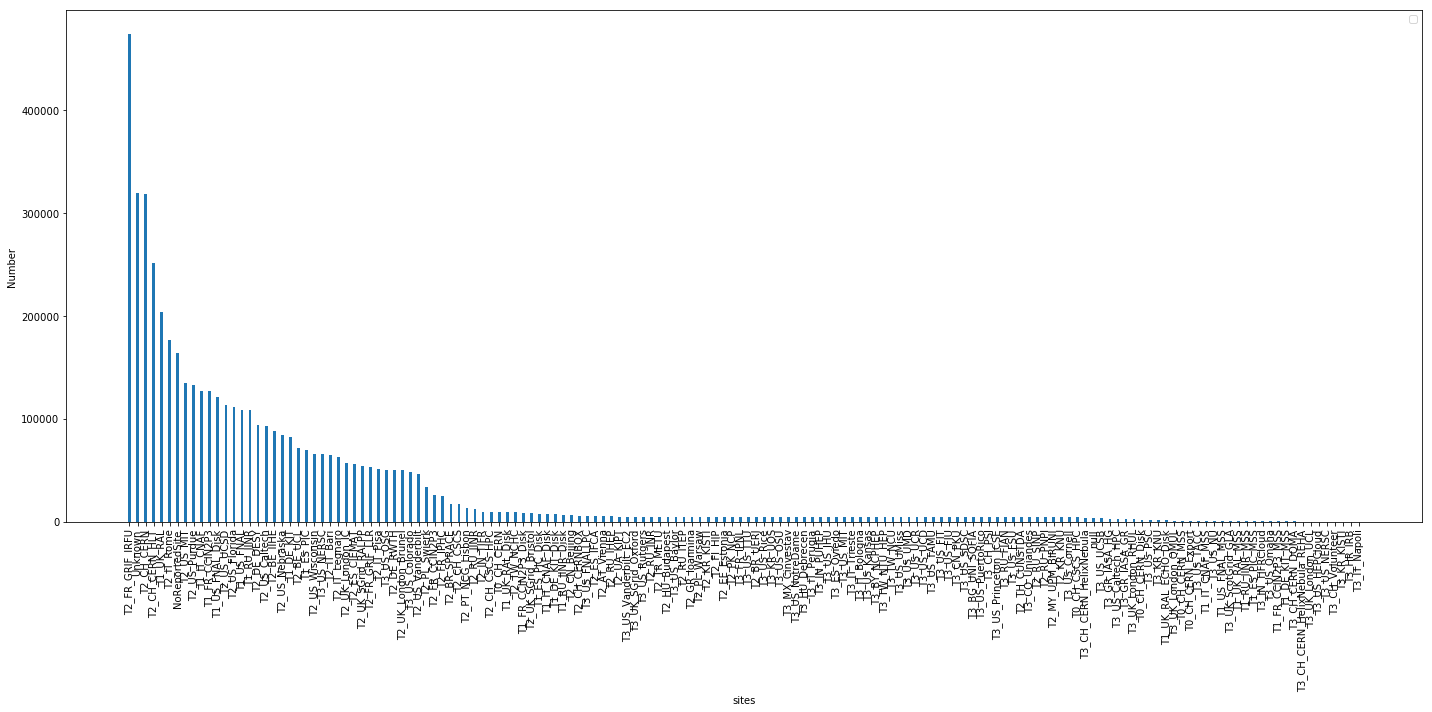

In [122]:
plot_counts(keys_all, 'site', 'sites')

### Unweighted

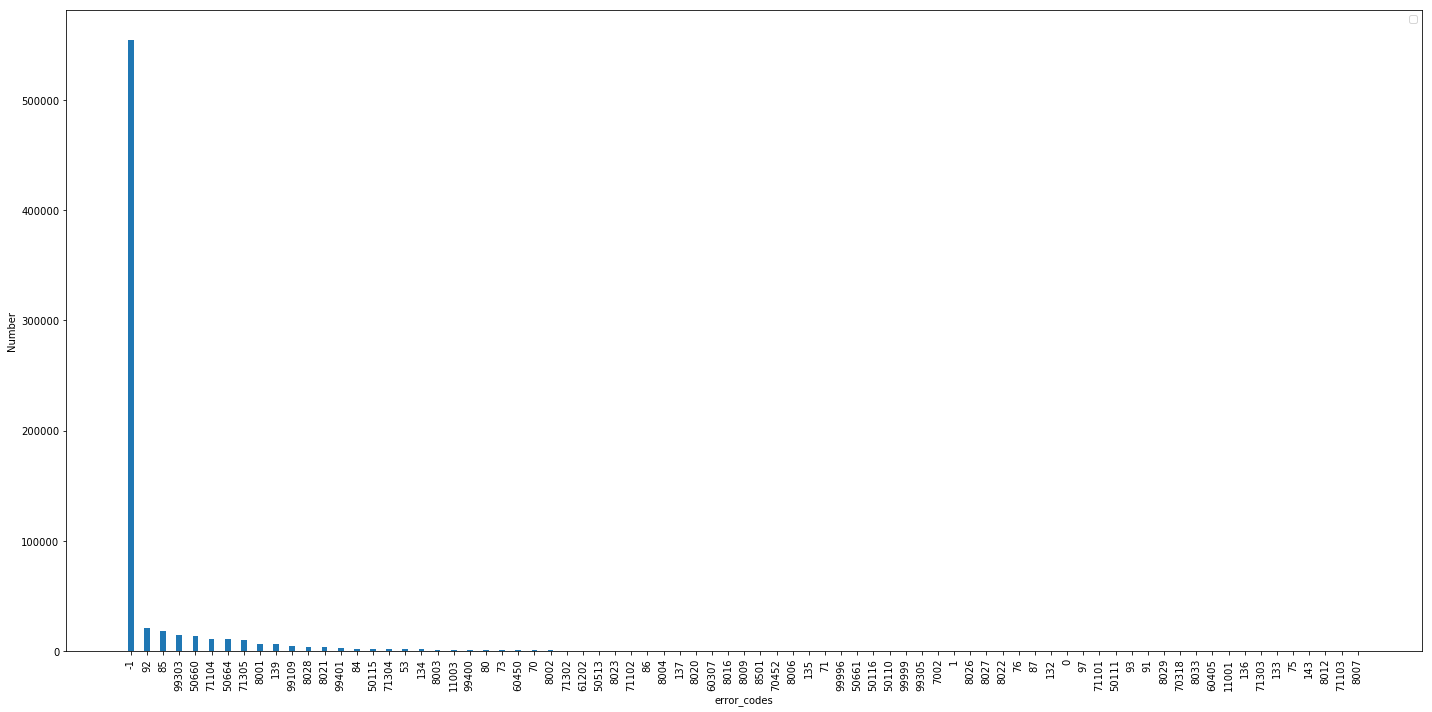

In [125]:
# With -1 codes
plot_counts(keys_all, 'error', 'error_codes', weighted = False)

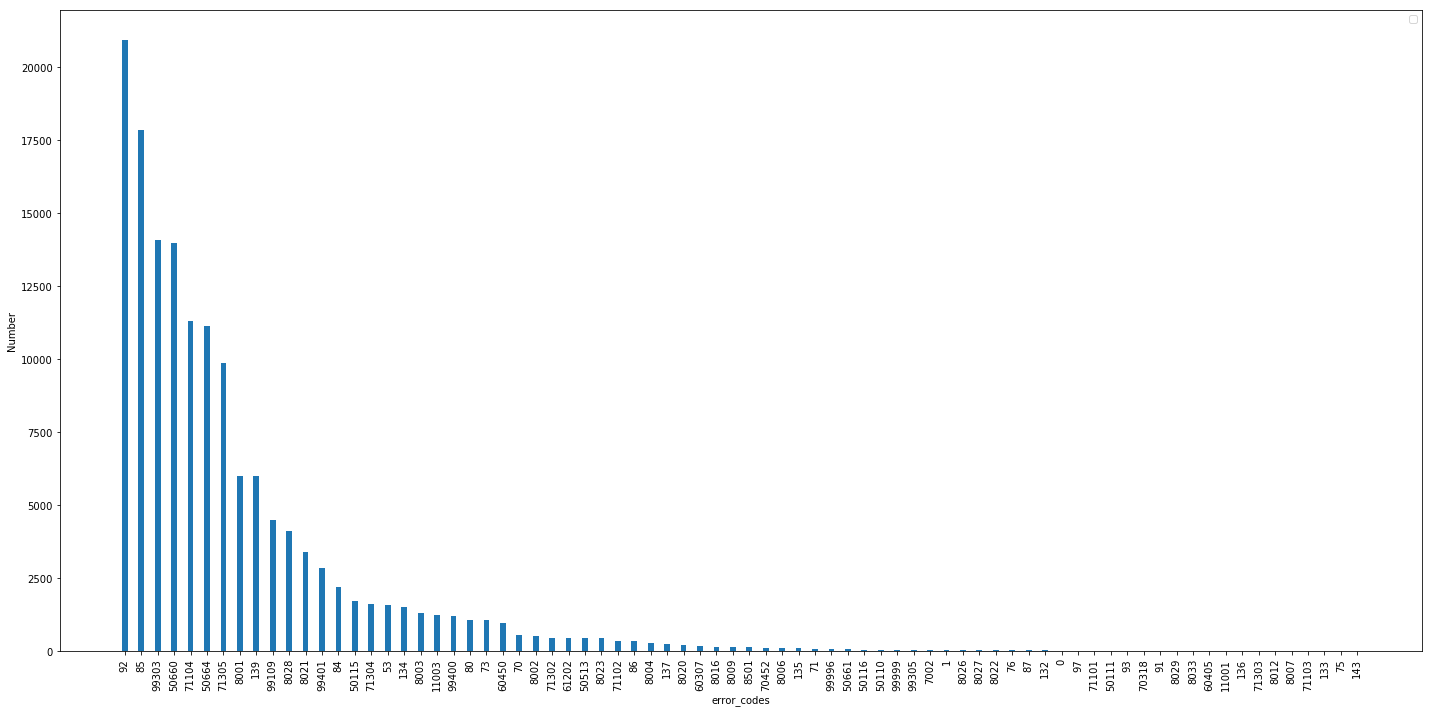

In [124]:
# Without -1 codes
plot_counts(keys_non_neg, 'error', 'error_codes', weighted = False)

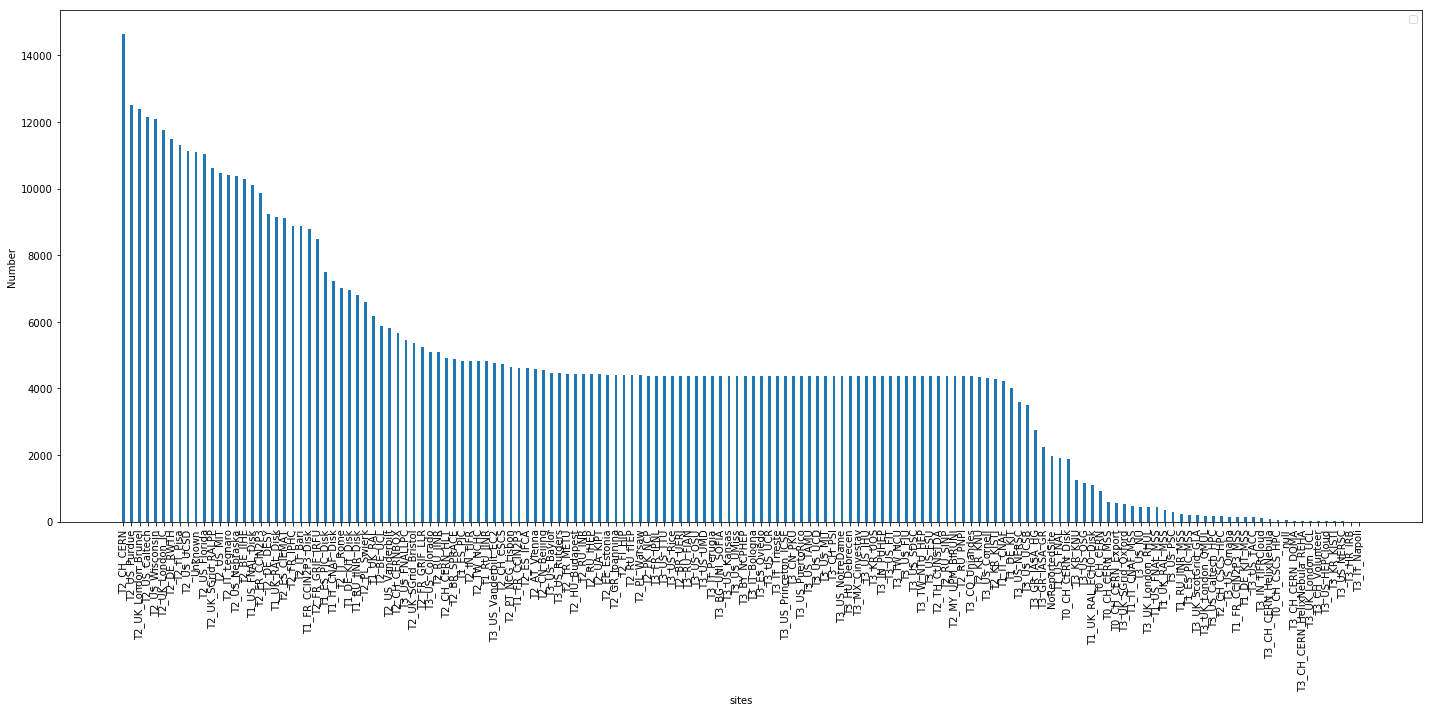

In [126]:
plot_counts(keys_all, 'site', 'sites', weighted = False)

## 2. Plot the fraction of the errors and sites found in the wmarchive

In [136]:
def load_data():
    
    time_chunks =  [(20170101, 20171009),(20171011, 20180301),(20180301, 20180601),
                    (20180601, 20181101),(20181101, 20190207),(20190207, 20190801)]
    
    dfs = []
    for time in time_chunks:
        t1, t2 = str(time[0]), str(time[1])
        frame = pd.read_hdf( 'data/messages_filtered_' + t1 + '_' + t2 + '.h5' )
        dfs.append( frame[['task_name', 'error',  'site', 'error_msg']])
        
    dfs = pd.concat(dfs, ignore_index=True)
    dfs = dfs.drop_duplicates()
    
    return dfs

wmarchive_messages = load_data()

In [137]:
# Merge
wmarchive_messages.error = wmarchive_messages.error.astype(int)
keys_non_neg.error = keys_non_neg.error.astype(int)
df = pd.merge(keys_non_neg , wmarchive_messages, on = ['task_name', 'site', 'error'], how='left')

In [138]:
def plot_found_messages(df_merged, col):
    
    df_has_msg = df_merged[df_merged['error_msg'].isna() == False]
    df_no_msg = df_merged[df_merged['error_msg'].isna() == True]

    frac = float(len(df_has_msg)) / float(len(df_merged))
    
    error_has_msg = df_has_msg['task_name'].groupby([df_has_msg[col]]).size().to_frame('has_msg')
    error_no_msg = df_no_msg['task_name'].groupby([df_no_msg[col]]).size().to_frame('no_msg')
    
    merged = pd.merge(error_has_msg , error_no_msg, on = [col], how='outer').fillna(0.).reset_index()
    
    def get_frac(row):
        
        has_msg = row['has_msg']
        no_msg = row['no_msg']
        return has_msg / float(has_msg + no_msg)
    
    merged['frac'] = merged.apply(lambda x: get_frac(x), axis=1)
    return merged, frac

In [149]:
from matplotlib.pyplot import hist
#plt.rcParams.update({'font.size': 12})

def plot_fractions(key, x_label = 'error_code'):
    
    error, frac = plot_found_messages(df, key)
    
    labels = error[key]
    
    if key == 'site':
        l = []
        for label in labels:
            try: 
                l.append(label.encode('utf-8'))           
            except:
                l.append('T3_US_NERSC'.encode('utf-8'))
        labels = l
    
    x = np.arange(len(labels))
    y = error.frac
    width = 0.35  

    fig, ax = plt.subplots(figsize=(20,10))
    rects1 = ax.bar(x, y, width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel(x_label)
    ax.set_ylabel('Fraction of found messages')
    ax.set_title('Total fraction of messages found: ' + str(frac))
    #ax.set_xticks(x)
    #ax.set_xticklabels(labels)
    plt.xticks(x, labels, rotation='vertical')
    ax.legend()

    fig.tight_layout()

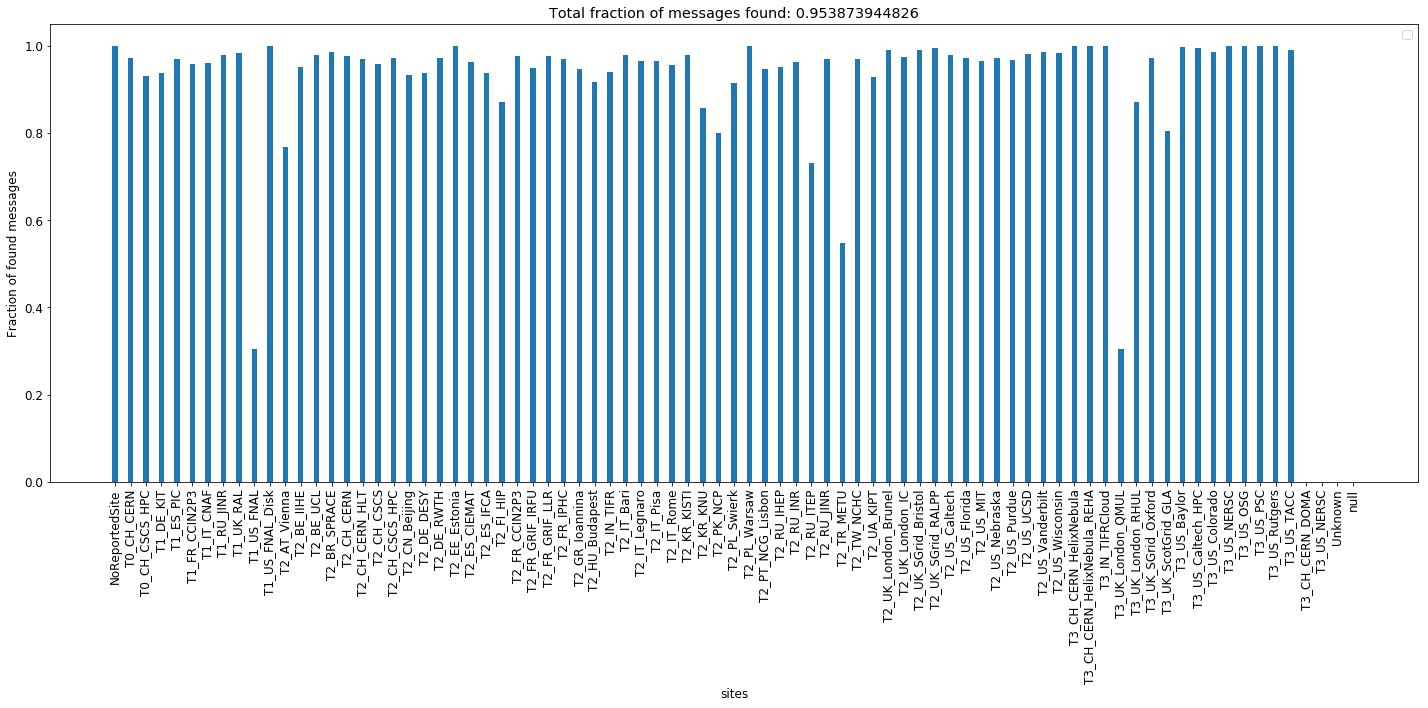

In [150]:
plot_fractions('site', 'sites')

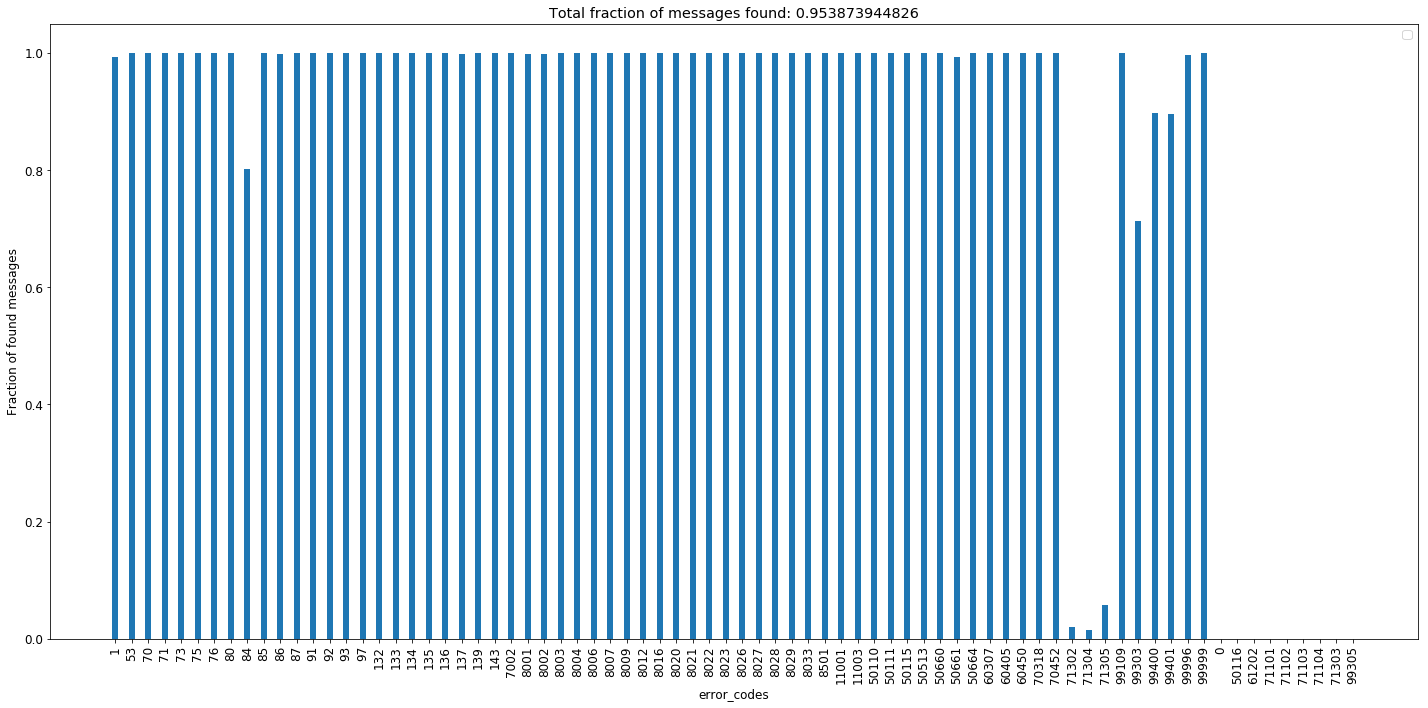

In [151]:
plot_fractions('error', 'error_codes')